# Chapter 6: Fundamentals of Fluid Flow (Diffusivity Equation)
**Author:** Ade Anggi Naluriawan Santoso

**Objective:**
In this notebook, we will model **Transient Flow** (Infinite-Acting flow) in a reservoir.

**The Theory:**
The flow of fluid through porous media is governed by the **Radial Diffusivity Equation**, which combines Darcy's Law (transport) with the Equation of Continuity (mass balance):

$$\frac{\partial^2 p}{\partial r^2} + \frac{1}{r} \frac{\partial p}{\partial r} = \left( \frac{\phi \mu c_t}{0.006328 k} \right) \frac{\partial p}{\partial t}$$

This is a Partial Differential Equation (PDE) describing how pressure $p$ changes with radius $r$ and time $t$.

**The Solution:**
For an infinite reservoir with a well producing at a constant rate $q$, the solution is the famous **Line Source Solution**, which uses the Exponential Integral ($Ei$) function:

$$p(r,t) = p_i + 70.6 \frac{q B \mu}{k h} \text{Ei} \left( - \frac{948 \phi \mu c_t r^2}{k t} \right)$$

In this exercise, we will:
1.  **Use Scipy** to calculate the $Ei$ function.
2.  **Visualize the Pressure Funnel:** Plot pressure distribution $P(r)$ at different times.
3.  **Visualize Drawdown:** Plot pressure drop $P(t)$ at the wellbore.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc # This contains the Exponential Integral (expi)

# Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. The Line Source Solution (Ei-Function)

The **Exponential Integral** function is defined as $\text{Ei}(-x) = -\int_{x}^{\infty} \frac{e^{-u}}{u} du$.

In Python's `scipy` library, this is available as `scipy.special.expi`.
* *Note:* The engineering texts usually write $Ei(-x)$, while Scipy's `expi(x)` expects a negative argument directly. We must be careful with signs.

Let's define a Python function for the Line Source Solution using Tarek Ahmed's Field Units.

In [2]:
def calc_pressure_line_source(t, r, pi, q, B, mu, k, h, phi, ct):
    """
    Calculates pressure at radius 'r' and time 't' using the Line Source Solution.
    
    Units:
    t (hours), r (ft), pi (psi), q (stb/d), B (rb/stb), 
    mu (cp), k (md), h (ft), phi (fraction), ct (1/psi)
    """
    
    # 1. Calculate the Diffusivity Constant (eta) for cleaner code
    # eta = k / (phi * mu * ct) is strictly diffusivity, 
    # but the argument inside Ei includes conversion factors for field units.
    
    # Argument X = (948 * phi * mu * ct * r^2) / (k * t)
    # Note: 948 is the conversion factor for Oilfield Units
    
    # Safety check for t=0 to avoid division by zero
    if t == 0:
        return pi
        
    x_arg = - (948 * phi * mu * ct * (r**2)) / (k * t)
    
    # 2. Calculate the Ei function value
    # sc.expi expects the negative value directly
    ei_value = sc.expi(x_arg)
    
    # 3. Calculate Pressure Drop (Delta P)
    # Constant term = 70.6 * (q * B * mu) / (k * h)
    dp = 70.6 * (q * B * mu) / (k * h) * ei_value
    
    # 4. Final Pressure
    # Since Ei returns a negative number for negative arguments, 
    # and the equation is Pi + (Constant * Ei), the pressure will drop.
    p_rt = pi + dp
    
    return p_rt

## 2. Visualization 1: The Pressure Funnel (P vs r)

Imagine we turn on a well and let it run. We want to see how the pressure wave moves outward into the reservoir after **1 hour, 10 hours, and 100 hours**.

**Reservoir Parameters:**
* $P_i = 5000$ psi
* $q = 500$ STB/D
* $k = 50$ md
* $h = 100$ ft
* $c_t = 15 \times 10^{-6}$ psi$^{-1}$

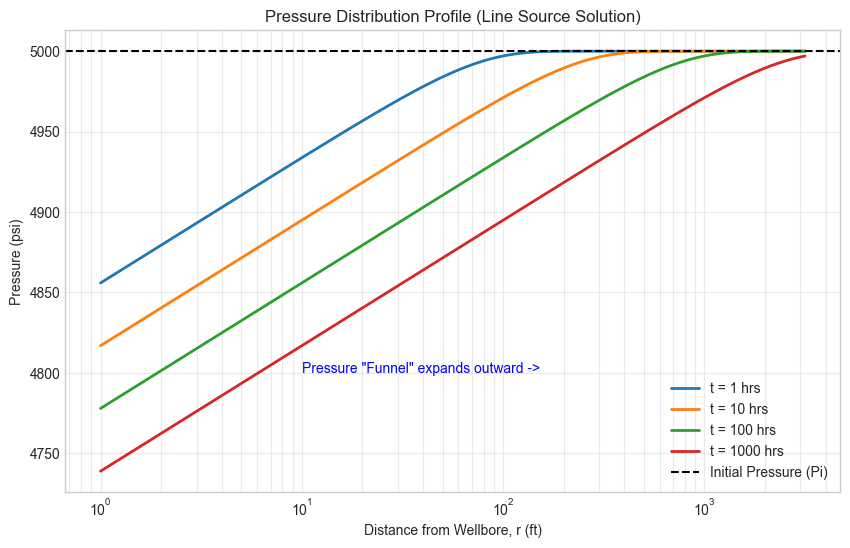

In [3]:
# --- INPUT PARAMETERS ---
Pi = 5000.0  # Initial Pressure (psi)
q = 500.0    # Flow Rate (stb/d)
Bo = 1.2     # FVF (rb/stb)
mu_o = 2.0   # Viscosity (cp)
k_res = 50.0 # Permeability (md)
h_res = 100.0# Thickness (ft)
phi = 0.20   # Porosity
ct = 15e-6   # Total Compressibility (1/psi)

# Radii to investigate (Logarithmic scale usually looks better)
radii = np.logspace(0, 3.5, 100) # From 1 ft to 3000 ft

# Times to investigate (hours)
times = [1, 10, 100, 1000] 

# --- CALCULATE & PLOT ---
plt.figure()

for time in times:
    pressures = []
    for r in radii:
        p = calc_pressure_line_source(time, r, Pi, q, Bo, mu_o, k_res, h_res, phi, ct)
        pressures.append(p)
    
    plt.semilogx(radii, pressures, linewidth=2, label=f't = {time} hrs')

# Plot Aesthetics
plt.title('Pressure Distribution Profile (Line Source Solution)')
plt.xlabel('Distance from Wellbore, r (ft)')
plt.ylabel('Pressure (psi)')
plt.axhline(Pi, color='k', linestyle='--', label='Initial Pressure (Pi)')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.4)

# Add Annotation
plt.text(10, 4800, 'Pressure "Funnel" expands outward ->', fontsize=10, color='blue')

plt.show()

**Observation:**
Notice how the "disturbance" travels.
* At **1 hour**, the pressure has only dropped near the wellbore (< 100 ft).
* At **1000 hours**, the pressure drop is felt over 2000 ft away.
* This visualizes the concept of **Radius of Investigation ($r_{inv}$)**.

## 3. Visualization 2: Drawdown Test (P vs t)

Now, let's stand at a fixed location (the wellbore, $r_w = 0.3$ ft) and watch the pressure drop over time. This is what we record during a real **Flow Test**.

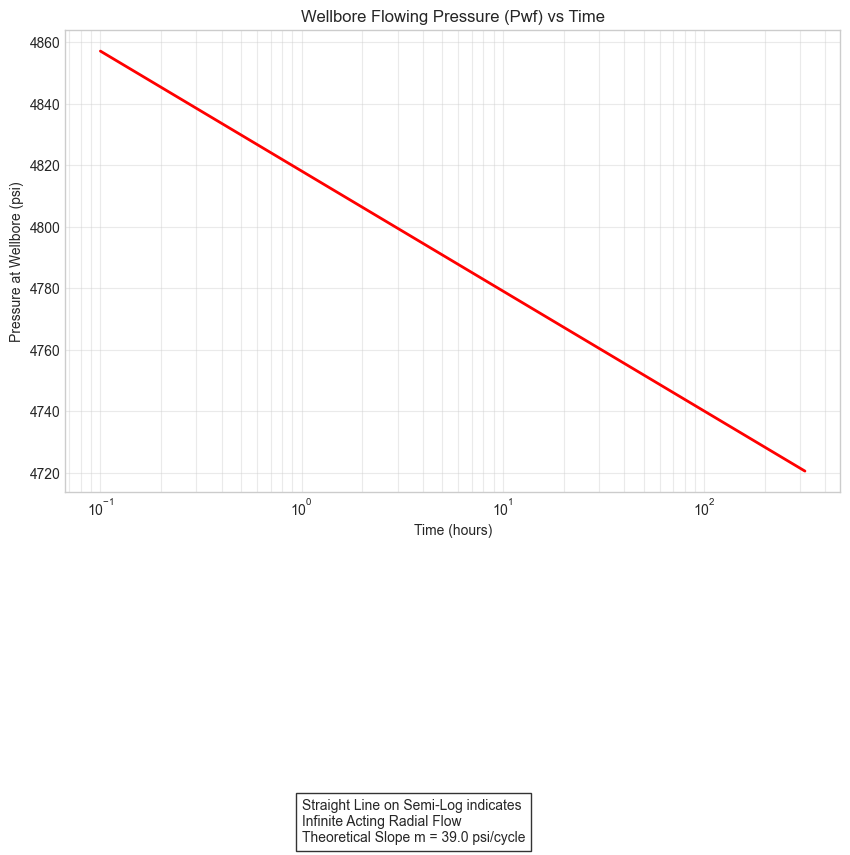

In [4]:
# Fixed Radius (at the wellbore face)
rw = 0.328 # ft (approx 7 7/8 inch hole)

# Time range (from 0.1 hr to 100 hrs)
time_range = np.logspace(-1, 2.5, 100)
p_wf = []

for t in time_range:
    p = calc_pressure_line_source(t, rw, Pi, q, Bo, mu_o, k_res, h_res, phi, ct)
    p_wf.append(p)

# Plotting Pwf vs Time (Semilog is standard for Well Testing)
plt.figure()
plt.semilogx(time_range, p_wf, 'r-', linewidth=2)

plt.title('Wellbore Flowing Pressure (Pwf) vs Time')
plt.xlabel('Time (hours)')
plt.ylabel('Pressure at Wellbore (psi)')
plt.grid(True, which="both", ls="-", alpha=0.4)

# Inverse slope calculation (m) just to demonstrate validity
# m = 162.6 * q * B * mu / (k * h)
m_slope = 162.6 * q * Bo * mu_o / (k_res * h_res)
plt.text(1, 4600, f'Straight Line on Semi-Log indicates\nInfinite Acting Radial Flow\nTheoretical Slope m = {m_slope:.1f} psi/cycle', 
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

## 4. Bonus: Numerical Solution (Finite Difference)

While the analytical solution is exact for simple cases, complex reservoirs require **Numerical Simulation**.

Here, we will solve the same Diffusivity Equation using the **Explicit Finite Difference Method**. We discretize the reservoir into grid blocks (rings) and solve for time steps.

Equation for Block $i$:
$$P_i^{n+1} = P_i^n + \frac{k \Delta t}{\phi \mu c_t \Delta r^2} (P_{i+1}^n - 2P_i^n + P_{i-1}^n)$$
*(Simplified 1D form)*

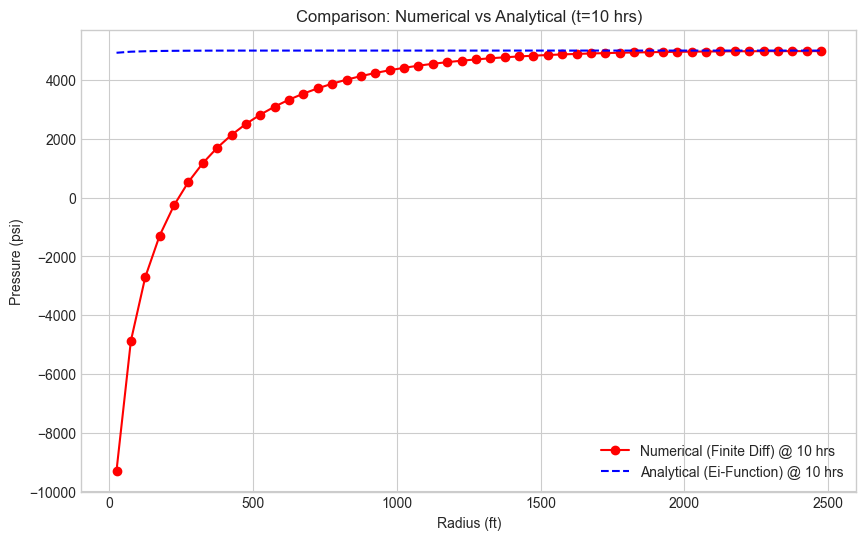

In [5]:
# --- 1D RADIAL FINITE DIFFERENCE SOLVER ---

# Grid Setup
N_blocks = 50
dr = 50.0  # Block size (ft)
dt = 0.1   # Time step (hours)
t_max = 10 # Simulate up to 10 hours

# Radial distances
r_nodes = np.linspace(dr/2, N_blocks*dr - dr/2, N_blocks)

# Properties
alpha = (0.006328 * k_res) / (phi * mu_o * ct) # Diffusivity Constant (field units)

# Stability Check (CFL Condition)
# Ideally dt should be small enough: dt < 0.5 * dr^2 / alpha
stability_limit = 0.5 * (dr**2) / alpha
if dt > stability_limit:
    print(f"Warning: Time step {dt} too large! Reducing to stable limit.")
    dt = stability_limit * 0.8

# Initialize Pressure Array (All blocks at Pi)
P_old = np.full(N_blocks, Pi)
P_new = np.zeros(N_blocks)

# Simulation Loop
steps = int(t_max / dt)
sim_time = 0

for n in range(steps):
    
    # 1. Inner Boundary (Well) - Constant Rate
    # q is withdrawn from Block 0
    # Darcy: q = 0.001127 * k * A * dp/dr
    # Simplified source term subtraction for Block 0
    V_block = np.pi * ((r_nodes[0] + dr/2)**2 - (r_nodes[0] - dr/2)**2) * h_res / 5.615
    q_term = (q * Bo * dt) / (V_block * phi * ct) 
    
    # 2. Update Inner Blocks (Simplified Logic)
    for i in range(1, N_blocks - 1):
        # Finite Difference approximation of d2p/dr2 + (1/r)dp/dr
        # Transmissibility Terms
        r_i = r_nodes[i]
        lambda_val = (alpha * dt) / (dr**2)
        
        # Explicit update
        P_new[i] = P_old[i] + lambda_val * (P_old[i+1] - 2*P_old[i] + P_old[i-1]) + \
                   (alpha * dt / (r_i * 2 * dr)) * (P_old[i+1] - P_old[i-1])

    # Apply Well Condition to Block 0 (Simple sink approximation)
    P_new[0] = P_old[0] - q_term 
    
    # Outer Boundary (No Flow) -> P_new[-1] = P_new[-2]
    P_new[-1] = P_new[-2]
    
    # Update time
    P_old = P_new.copy()
    sim_time += dt

# Plot Numerical Result vs Analytical
plt.figure()
plt.plot(r_nodes, P_new, 'ro-', label=f'Numerical (Finite Diff) @ {t_max} hrs')

# Compare with Analytical at exact same time
p_analytical = [calc_pressure_line_source(t_max, r, Pi, q, Bo, mu_o, k_res, h_res, phi, ct) for r in r_nodes]
plt.plot(r_nodes, p_analytical, 'b--', label=f'Analytical (Ei-Function) @ {t_max} hrs')

plt.title(f'Comparison: Numerical vs Analytical (t={t_max} hrs)')
plt.xlabel('Radius (ft)')
plt.ylabel('Pressure (psi)')
plt.legend()
plt.grid(True)
plt.show()

## Conclusion

1.  **Transient Flow:** We visualized how the pressure disturbance moves away from the wellbore over time using the **Ei-Function**.
2.  **Semi-Log Plot:** We confirmed that during transient flow, pressure vs. time forms a straight line on a semi-log plot (the basis of well testing).
3.  **Numerical Simulation:** We demonstrated that a simple finite-difference loop in Python can approximate the analytical solution, paving the way for simulating complex reservoirs where analytical equations fail.